In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
import warnings

In [2]:
# suppress warnings

# since market data is not always available on weekdays, we cannot set frequency...
warnings.filterwarnings('ignore', category=ValueWarning)
# we are brute forcing to find the best parameters, so not all models will converge
warnings.filterwarnings('ignore', category=ConvergenceWarning)
# not all starting parameters are gonna be valid either
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
# constants
INITIAL_INVESTMENT = 100
TICKERS = ['^GSPC', 'COST', 'AC.TO', 'BTC-USD']

# train on 2023 data, test on ytd data
TRAIN_START_DATE = '2023-01-01'
TRAIN_END_DATE = '2023-12-31'
TEST_START_DATE = '2024-01-01'
TEST_END_DATE = datetime.today().strftime('%Y-%m-%d')

In [4]:
# prepare data
train_data, test_data = {}, {}

for ticker in TICKERS:
    df1 = yf.download(ticker, start=TRAIN_START_DATE, end=TRAIN_END_DATE).dropna()
    df2 = yf.download(ticker, start=TEST_START_DATE, end=TEST_END_DATE).dropna()
    
    # drop columns we dont need
    df1.drop(columns=['Open','High','Low','Adj Close','Volume'], inplace=True)
    df2.drop(columns=['Open','High','Low','Adj Close','Volume'], inplace=True)
    
    # rename columns
    df1.rename(columns={'Close': 'price'}, inplace=True)
    df2.rename(columns={'Close': 'price'}, inplace=True)
    
    # set index as datetime
    df1.index = pd.to_datetime(df1.index)
    df2.index = pd.to_datetime(df2.index)
    
    train_data[ticker] = df1.copy()
    test_data[ticker] = df2.copy()
    
    # infer frequency. dont do this if you have daily prices
    # train_data[ticker] = train_data[ticker].asfreq(pd.infer_freq(train_data[ticker].index))
    # test_data[ticker] = test_data[ticker].asfreq(pd.infer_freq(test_data[ticker].index))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
# check volatility of training data. We dont want to predict on very volatile data
for ticker in TICKERS:
    print(f'{ticker} volatility: {train_data[ticker]["price"].pct_change().std()*100}%')

^GSPC volatility: 0.8258446240163895%
COST volatility: 1.2068258522928514%
AC.TO volatility: 1.8278406029296934%
BTC-USD volatility: 2.297095578968665%


In [6]:
# simulation plot function
def plot_simulation(data: dict, transactions: dict, title: str, plot_cols=['price'], plot_labels=['Price']) -> None:
    if len(data) == 1:
        ticker = TICKERS[0]
        df = data[ticker]
        
        plt.figure(figsize=(12, 5))
        plt.grid()
        
        for col in plot_cols:
            plt.plot(df[col], label=col)

        current_val = transactions[ticker][-1]['value'] if transactions[ticker] else INITIAL_INVESTMENT
        returns = (current_val - INITIAL_INVESTMENT) / INITIAL_INVESTMENT
        text = (
            f'Strategy: {title} (${INITIAL_INVESTMENT} Initial Investment)\n'
            f'Value: ${np.round(current_val, 2)}, Returns: {np.round(returns*100, 2)}%'
        )
        plt.title(text)
        
        # vertical lines for transactions
        y_limits = [df['price'].min(), df['price'].max()]
        for n in range(0, len(transactions[ticker])-1, 2):
            plt.axvline(transactions[ticker][n]['date'], color='r' , linestyle='--')
            plt.axvline(transactions[ticker][n+1]['date'], color='g' , linestyle='--')
            
            shade_color = 'green' if transactions[ticker][n+1]['price'] > transactions[ticker][n]['price'] else 'red'
            plt.fill_betweenx(y_limits, transactions[ticker][n]['date'], transactions[ticker][n+1]['date'], color=shade_color, alpha=0.1)
            
        # legend
        custom_labels = [f'{ticker} {label}' for label in plot_labels] + ['Buy Transaction', 'Sell Transaction']
        plt.legend(custom_labels)
        
    # use subplots for multiple tickers
    elif len(data) > 1:
        fig, axs = plt.subplots(len(data), 1, figsize=(12, 3*len(data)))
    
        for i, (ticker, df) in enumerate(data.items()):
            for col in plot_cols:
                axs[i].plot(df[col], label=col)

            
            current_val = transactions[ticker][-1]['value'] if transactions[ticker] else INITIAL_INVESTMENT
            returns = (current_val - INITIAL_INVESTMENT) / INITIAL_INVESTMENT
            text = f'Current Value: ${np.round(current_val, 2)}, Returns: {np.round(returns*100, 2)}%'
            axs[i].set_title(text)
            axs[i].grid()
            
            # vertical lines for transactions
            y_limits = [df['price'].min(), df['price'].max()]
            for n in range(0, len(transactions[ticker])-1, 2):
                axs[i].axvline(transactions[ticker][n]['date'], color='r' , linestyle='--')
                axs[i].axvline(transactions[ticker][n+1]['date'], color='g' , linestyle='--')
                
                shade_color = 'green' if transactions[ticker][n+1]['price'] > transactions[ticker][n]['price'] else 'red'
                axs[i].fill_betweenx(y_limits, transactions[ticker][n]['date'], transactions[ticker][n+1]['date'], color=shade_color, alpha=0.1)
                
            # legend
            custom_labels = [f'{ticker} {label}' for label in plot_labels] + ['Buy Transaction', 'Sell Transaction']
            axs[i].legend(custom_labels)
            
        fig.suptitle(f'Strategy: {title} (${INITIAL_INVESTMENT} Initial Investment)')
        fig.tight_layout()

#### 1. Buying at the start and holding till the end

In [7]:
trans1 = {}

for ticker in TICKERS:
    trans1.setdefault(ticker, []).append({
        'date': test_data[ticker].index[0],
        'price': test_data[ticker]['price'].iloc[0],
        'action': 'buy',
        'value': INITIAL_INVESTMENT
    })
    
    trans1.setdefault(ticker, []).append({
        'date': test_data[ticker].index[-1],
        'price': test_data[ticker]['price'].iloc[-1],
        'action': 'sell',
        'value':  INITIAL_INVESTMENT * test_data[ticker]['price'].iloc[-1] / test_data[ticker]['price'].iloc[0]
    })


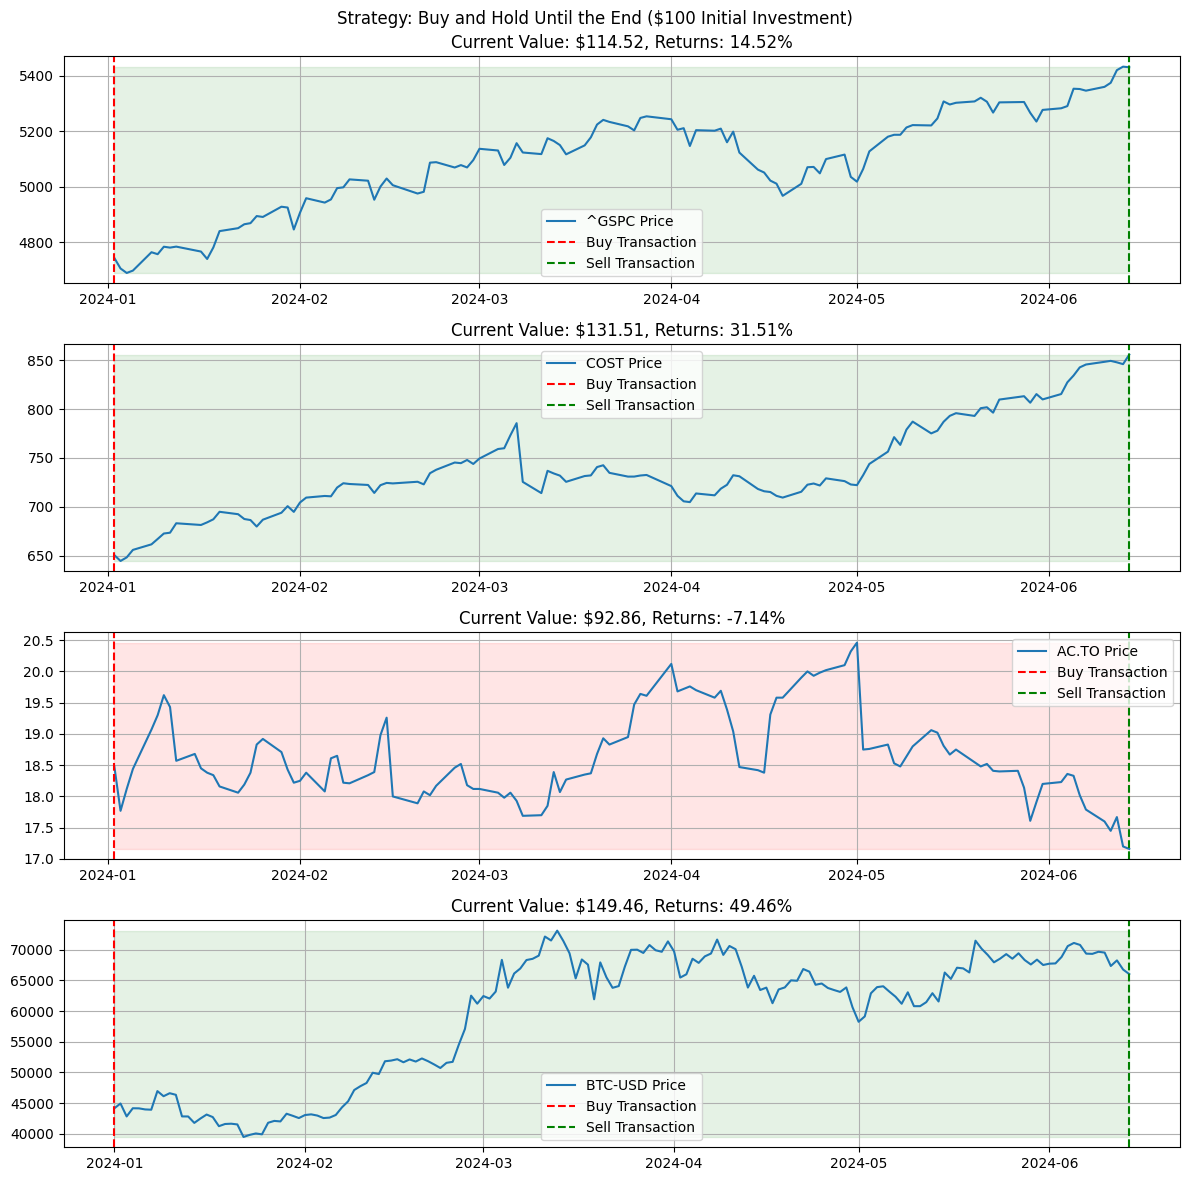

In [8]:
plot_simulation(test_data, trans1, 'Buy and Hold Until the End')

#### 2. Buying after stonks go up, selling after stocks go down

In [9]:
trans2 = {ticker: [] for ticker in TICKERS}

for ticker in TICKERS:
    for i in range(1, len(test_data[ticker])-1):
        curr_price = test_data[ticker]['price'].iloc[i]
        prev_price = test_data[ticker]['price'].iloc[i-1]
        last_trans = trans2[ticker][-1]['action'] if len(trans2[ticker])>0 else 'sell'
        
        # buy if price went up today
        if curr_price > prev_price and last_trans == 'sell':
            trans2[ticker].append({
                'date': test_data[ticker].index[i],
                'price': curr_price,
                'action': 'buy',
                'value': INITIAL_INVESTMENT if len(trans2[ticker])==0 else trans2[ticker][-1]['value']
            })
            
        # sell if price went down today
        elif curr_price < prev_price and last_trans == 'buy':
            returns = (curr_price - trans2[ticker][-1]['price']) / trans2[ticker][-1]['price']
            trans2[ticker].append({
                'date': test_data[ticker].index[i],
                'price': curr_price,
                'action': 'sell',
                'value': (returns+1) * trans2[ticker][-1]['value']
            })
            
        # sell on last day
        elif i == len(test_data[ticker])-1 and last_trans == 'buy':
            returns = (curr_price - trans2[ticker][-1]['price']) / trans2[ticker][-1]['price']
            trans2[ticker].append({
                'date': test_data[ticker].index[i],
                'price': curr_price,
                'action': 'sell',
                'value': (returns+1) * trans2[ticker][-1]['value']
            })

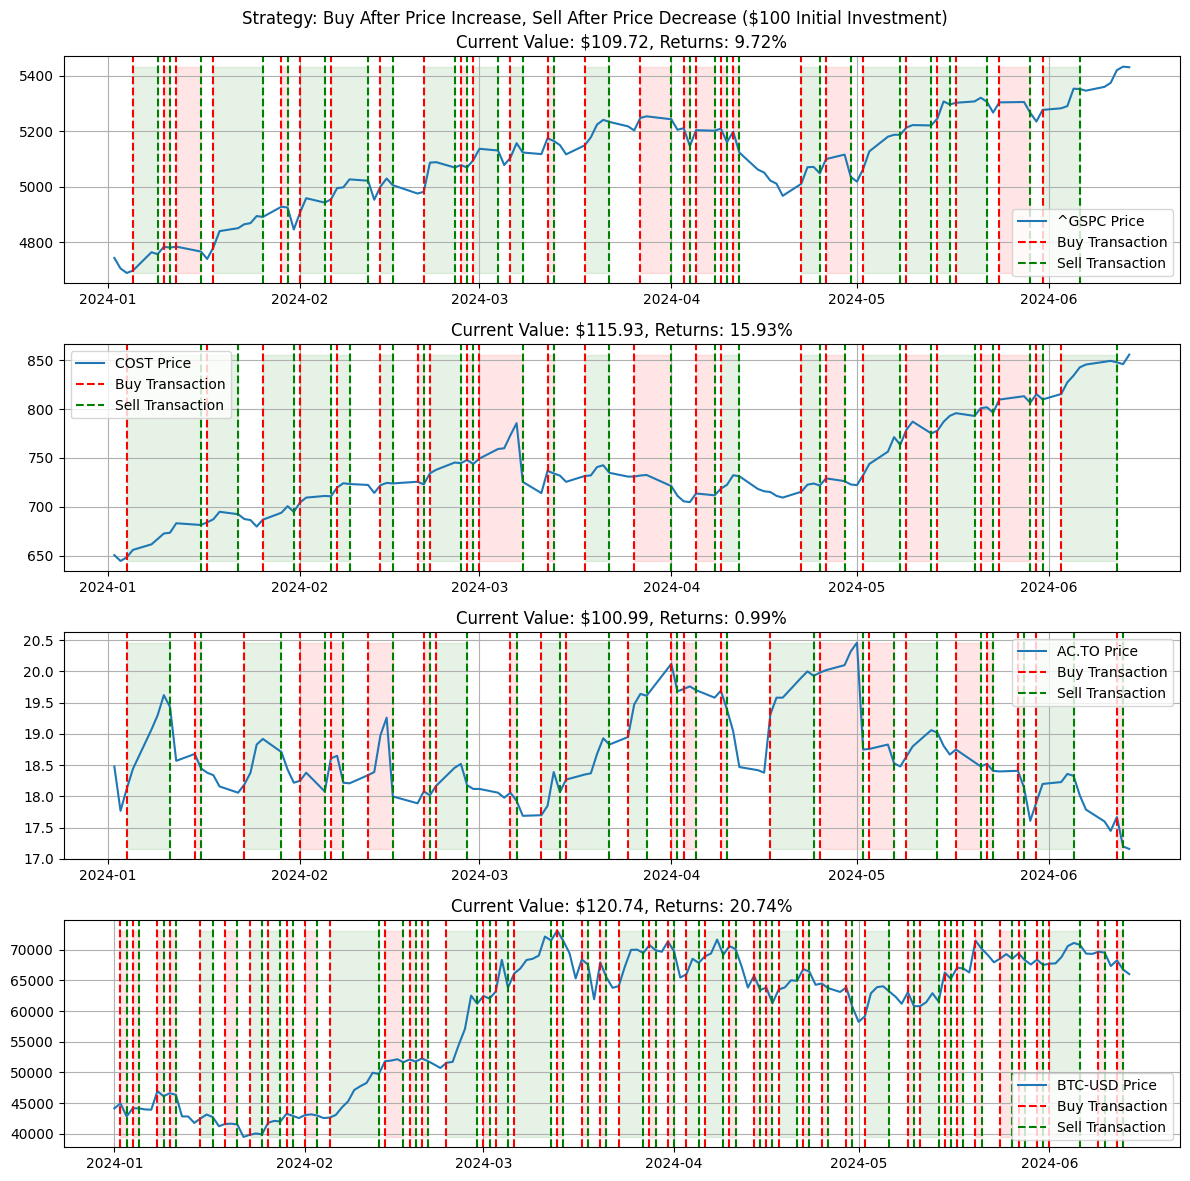

In [10]:
plot_simulation(test_data, trans2, 'Buy After Price Increase, Sell After Price Decrease')

#### 3. Buying if the stock goes up, selling the day after

In [11]:
trans3 = {ticker: [] for ticker in TICKERS}

for ticker in TICKERS:
    for i in range(1, len(test_data[ticker])-1):
        curr_price = test_data[ticker]['price'].iloc[i]
        prev_price = test_data[ticker]['price'].iloc[i-1]
        last_trans = trans3[ticker][-1]['action'] if len(trans3[ticker])>0 else 'sell'
        
        # buy if price today is higher than yesterday
        if curr_price > prev_price and last_trans == 'sell':
            trans3[ticker].append({
                'date': test_data[ticker].index[i],
                'price': curr_price,
                'action': 'buy',
                'value': INITIAL_INVESTMENT if len(trans3[ticker])==0 else trans3[ticker][-1]['value']
            })
            
        # sell day after buy
        elif last_trans=='buy':
            returns = (curr_price - trans3[ticker][-1]['price']) / trans3[ticker][-1]['price']
            trans3[ticker].append({
                'date': test_data[ticker].index[i],
                'price': curr_price,
                'action': 'sell',
                'value': (returns+1) * trans3[ticker][-1]['value']
            })
            
        # sell on last day if still holding stock
        elif i == len(test_data[ticker])-1 and last_trans == 'buy':
            returns = (curr_price - trans3[ticker][-1]['price']) / trans3[ticker][-1]['price']
            
            trans3[ticker].append({
                'date': test_data[ticker].index[i],
                'price': curr_price,
                'action': 'sell',
                'value': (returns+1) * trans3[ticker][-1]['value']
            })

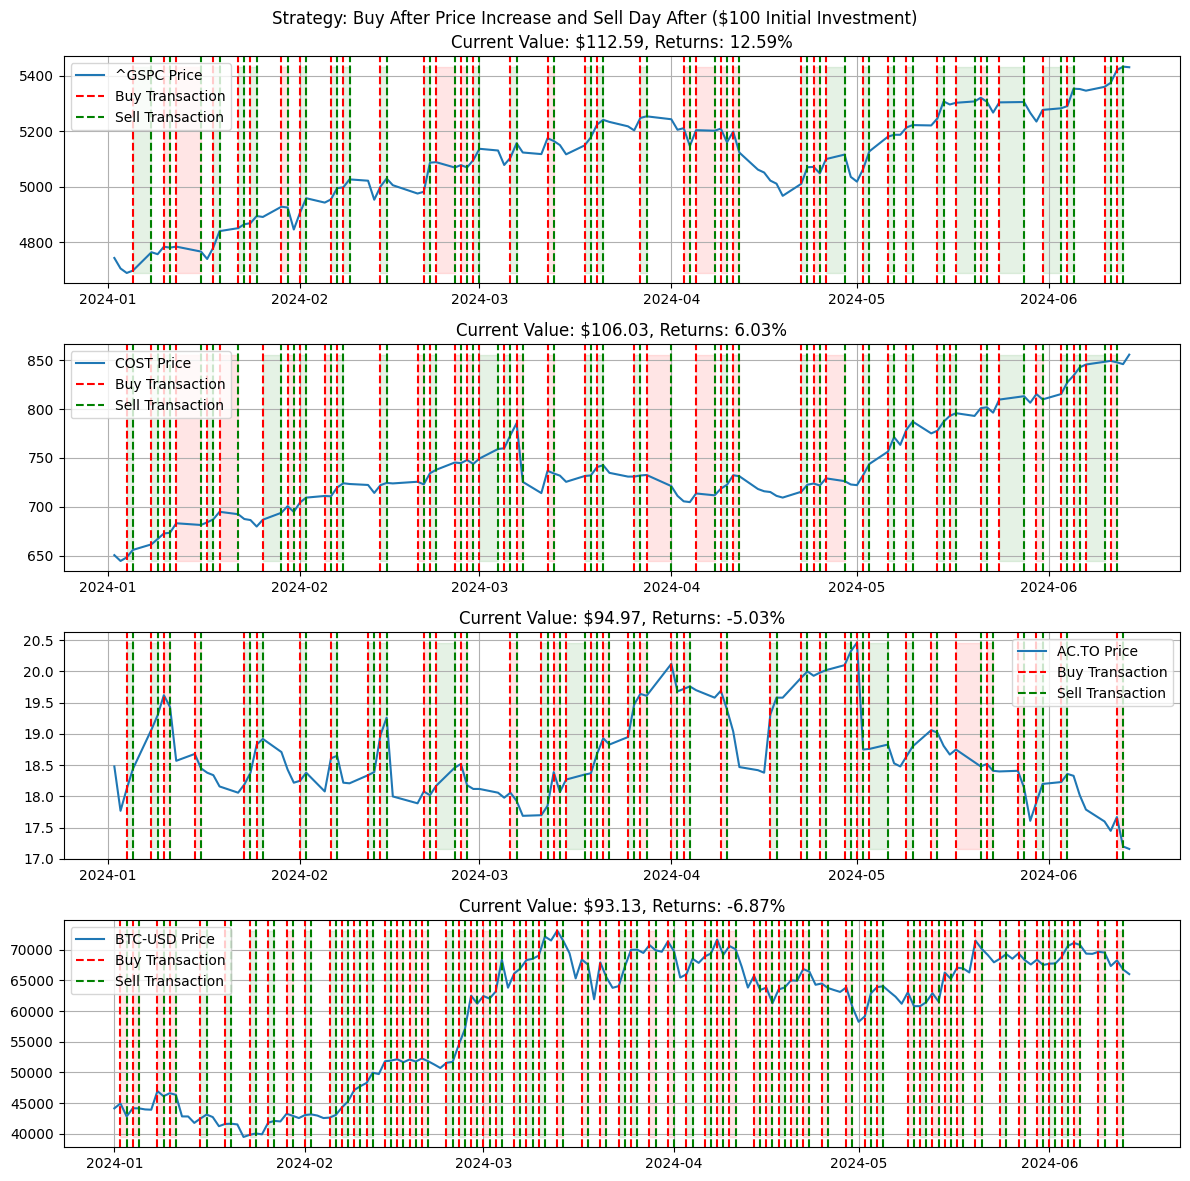

In [12]:
plot_simulation(test_data, trans3, 'Buy After Price Increase and Sell Day After')

### ARIMA Models

In [13]:
# generate candidate model orders
AR = [0, 1, 2, 3, 4, 5]
I = [0, 1, 2]
MA = [0, 1, 2, 3, 4, 5]

ignore_orders = [(0, 0, 0), (0, 1, 0), (0, 2, 0)]

model_orders = []
for p in AR:
    for i in I:
        for q in MA:
            if (p, i, q) not in ignore_orders:
                model_orders.append((p, i, q))

In [14]:
candidate_models = {}
aic = {}

for ticker, df in train_data.items():
    for order in model_orders:
        model = ARIMA(df['price'], order=order)
        fit = model.fit()
        print(f'Fit model for {ticker} of order: {order} AIC: {fit.aic}')
        
        candidate_models.setdefault(ticker, []).append(fit)
        aic.setdefault(ticker, []).append(fit.aic)

Fit model for ^GSPC of order: (0, 0, 1) AIC: 3153.735301062557
Fit model for ^GSPC of order: (0, 0, 2) AIC: 2943.371772357249
Fit model for ^GSPC of order: (0, 0, 3) AIC: 2885.721842181891
Fit model for ^GSPC of order: (0, 0, 4) AIC: 2868.71831561805
Fit model for ^GSPC of order: (0, 0, 5) AIC: 2886.540538445427
Fit model for ^GSPC of order: (0, 1, 1) AIC: 2477.8184974540845
Fit model for ^GSPC of order: (0, 1, 2) AIC: 2479.759413903096
Fit model for ^GSPC of order: (0, 1, 3) AIC: 2481.7100857222026
Fit model for ^GSPC of order: (0, 1, 4) AIC: 2483.5395296523084
Fit model for ^GSPC of order: (0, 1, 5) AIC: 2485.4374394226315
Fit model for ^GSPC of order: (0, 2, 1) AIC: 2472.190864504463
Fit model for ^GSPC of order: (0, 2, 2) AIC: 2473.783693252495
Fit model for ^GSPC of order: (0, 2, 3) AIC: 2475.646907821684
Fit model for ^GSPC of order: (0, 2, 4) AIC: 2477.5327135826383
Fit model for ^GSPC of order: (0, 2, 5) AIC: 2479.4431131256642
Fit model for ^GSPC of order: (1, 0, 0) AIC: 2494.

In [15]:
# find optimal model (lowest AIC)
optimal_orders = {}

for ticker in TICKERS:
    order = model_orders[np.argmin(aic[ticker])]
    optimal_orders[ticker] = order

    print(f'{ticker} optimal model: ARIMA{order} \n')

^GSPC optimal model: ARIMA(0, 2, 1) 

COST optimal model: ARIMA(0, 2, 1) 

AC.TO optimal model: ARIMA(5, 1, 4) 

BTC-USD optimal model: ARIMA(2, 1, 0) 



In [16]:
# we will just fit the model and forecast the prices here in one go...
for ticker in TICKERS:
    ticker_forecasts = []
    
    for i, date in enumerate(test_data[ticker].index):
        # update training data with new data point
        new_train_data = pd.concat([train_data[ticker]['price'], test_data[ticker]['price'].iloc[:i]])
        model = ARIMA(new_train_data, order=optimal_orders[ticker])
        model_fit = model.fit()
        forecast = model_fit.forecast()
        ticker_forecasts.append(float(forecast.iloc[0]))
    
    test_data[ticker]['forecasts'] = ticker_forecasts

c:\Users\Yang\Documents\Projects\funance_blog\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Yang\Documents\Projects\funance_blog\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Yang\Documents\Projects\funance_blog\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Yang\Documents\Projects\funance_blog\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarn

#### 4. Buy when price increase is forecasted, sell when price decrease is forecasted

In [17]:
trans4 = {ticker: [] for ticker in TICKERS}

for ticker in TICKERS:
    for i in range(len(test_data[ticker])-1):
        curr_price = test_data[ticker]['price'].iloc[i]
        last_trans = trans4[ticker][-1]['action'] if len(trans4[ticker])>0 else 'sell'
        forecast = test_data[ticker]['forecasts'].iloc[i+1]
        prev_forecast = test_data[ticker]['forecasts'].iloc[i]
        
        # buy if forecast is higher than current price
        if forecast > prev_forecast and last_trans == 'sell':
            trans4[ticker].append({
                'date': test_data[ticker].index[i],
                'price': curr_price,
                'action': 'buy',
                'value': INITIAL_INVESTMENT if len(trans4[ticker])==0 else trans4[ticker][-1]['value']
            })
            
        # sell if forecast is lower than current price
        elif prev_forecast > forecast and last_trans=='buy':
            returns = (curr_price - trans4[ticker][-1]['price']) / trans4[ticker][-1]['price']
            trans4[ticker].append({
                'date': test_data[ticker].index[i],
                'price': curr_price,
                'action': 'sell',
                'value': (returns+1) * trans4[ticker][-1]['value']
            })
            
    # sell all holdings on last day if still holding
    if last_trans == 'buy':
        returns = (test_data[ticker]['price'].iloc[-1] - trans4[ticker][-1]['price']) / trans4[ticker][-1]['price']
        trans4[ticker].append({
            'date': test_data[ticker].index[-1],
            'price': test_data[ticker]['price'].iloc[-1],
            'action': 'sell',
            'value': (returns+1) * trans4[ticker][-1]['value']
        })

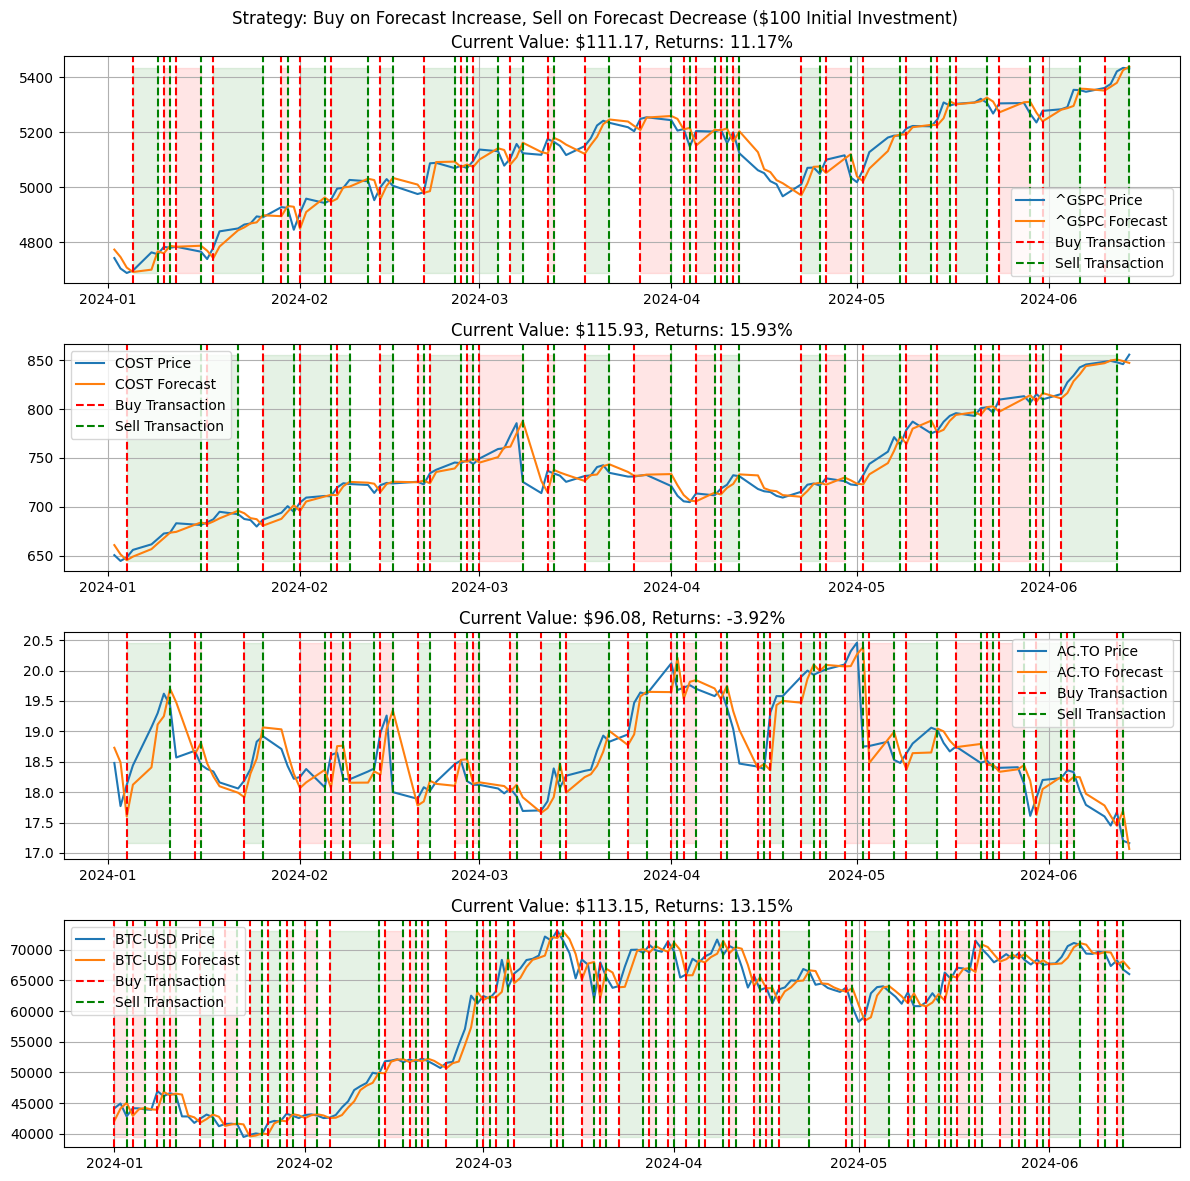

In [18]:
plot_simulation(test_data, trans4, 'Buy on Forecast Increase, Sell on Forecast Decrease', plot_cols=['price', 'forecasts'], plot_labels=['Price', 'Forecast'])

#### 5. Buy when price increase is forecasted, sell next day

In [19]:
trans5 = {ticker: [] for ticker in TICKERS}

for ticker in TICKERS:
    for i in range(len(test_data[ticker])-1):
        curr_price = test_data[ticker]['price'].iloc[i]
        last_trans = trans5[ticker][-1]['action'] if len(trans5[ticker])>0 else 'sell'
        forecast = test_data[ticker]['forecasts'].iloc[i+1]
        prev_forecast = test_data[ticker]['forecasts'].iloc[i]
        
        # buy if forecast is higher than current price
        if forecast > prev_forecast and last_trans == 'sell':
            trans5[ticker].append({
                'date': test_data[ticker].index[i],
                'price': curr_price,
                'action': 'buy',
                'value': INITIAL_INVESTMENT if len(trans5[ticker])==0 else trans5[ticker][-1]['value']
            })
            
        # sell if forecast is lower than current price
        elif last_trans=='buy':
            returns = (curr_price - trans5[ticker][-1]['price']) / trans5[ticker][-1]['price']
            trans5[ticker].append({
                'date': test_data[ticker].index[i],
                'price': curr_price,
                'action': 'sell',
                'value': (returns+1) * trans5[ticker][-1]['value']
            })
            
    # sell all holdings on last day if still holding
    if last_trans == 'buy':
        returns = (test_data[ticker]['price'].iloc[-1] - trans5[ticker][-1]['price']) / trans5[ticker][-1]['price']
        trans5[ticker].append({
            'date': test_data[ticker].index[-1],
            'price': test_data[ticker]['price'].iloc[-1],
            'action': 'sell',
            'value': (returns+1) * trans5[ticker][-1]['value']
        })

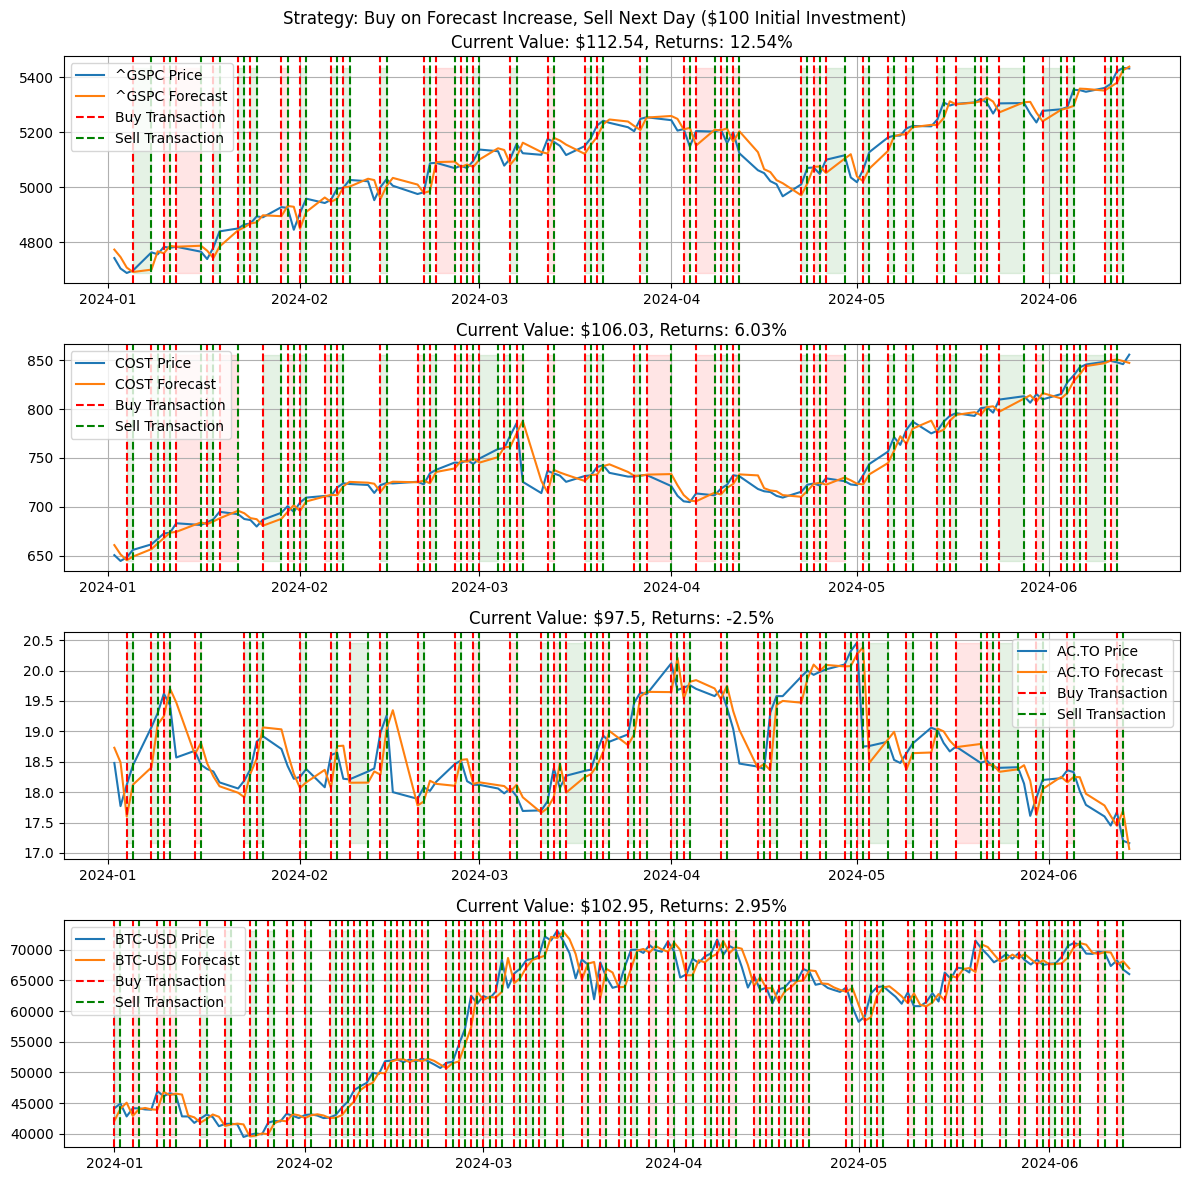

In [20]:
plot_simulation(test_data, trans5, 'Buy on Forecast Increase, Sell Next Day', plot_cols=['price', 'forecasts'], plot_labels=['Price', 'Forecast'])

### ARIMA model on returns

In [21]:
# prepare data
returns_train = train_data.copy()
returns_test = test_data.copy()

for ticker in TICKERS:
    returns_train[ticker]['returns'] = returns_train[ticker]['price'].pct_change()
    returns_test[ticker]['returns'] = returns_test[ticker]['price'].pct_change()
    
    returns_train[ticker] = returns_train[ticker].dropna()
    returns_test[ticker] = returns_test[ticker].dropna()
    
    # drop forecasts column from test data
    returns_test[ticker] = returns_test[ticker].drop(columns=['forecasts'])

In [23]:
returns_models = {}
returns_aic = {}

for ticker, df in returns_train.items():
    for order in model_orders:
        model = ARIMA(df['returns'], order=order)
        fit = model.fit()
        print(f'Fit model for {ticker} with order {order}, AIC: {fit.aic}')
        
        returns_models.setdefault(ticker, []).append(fit)
        returns_aic.setdefault(ticker, []).append(fit.aic)

Fit model for ^GSPC with order (0, 0, 1), AIC: -1677.1719258186095
Fit model for ^GSPC with order (0, 0, 2), AIC: -1675.2804822919497
Fit model for ^GSPC with order (0, 0, 3), AIC: -1673.4679110800153
Fit model for ^GSPC with order (0, 0, 4), AIC: -1671.5756203463707
Fit model for ^GSPC with order (0, 0, 5), AIC: -1669.8921106713515
Fit model for ^GSPC with order (0, 1, 1), AIC: -1665.7622126526494
Fit model for ^GSPC with order (0, 1, 2), AIC: -1664.0613954231198
Fit model for ^GSPC with order (0, 1, 3), AIC: -1662.1810834546136
Fit model for ^GSPC with order (0, 1, 4), AIC: -1655.42070729416
Fit model for ^GSPC with order (0, 1, 5), AIC: -1655.408727189103
Fit model for ^GSPC with order (0, 2, 1), AIC: -1494.2361013293894
Fit model for ^GSPC with order (0, 2, 2), AIC: -1637.6194887185065
Fit model for ^GSPC with order (0, 2, 3), AIC: -1640.3102479387685
Fit model for ^GSPC with order (0, 2, 4), AIC: -1634.1563823008603
Fit model for ^GSPC with order (0, 2, 5), AIC: -1632.221118780151

In [26]:
# find optimal model (lowest AIC)
returns_optimal_orders = {}

for ticker in TICKERS:
    order = model_orders[np.argmin(returns_aic[ticker])]
    returns_optimal_orders[ticker] = order

    print(f'{ticker} optimal model: ARIMA{order} \n')

^GSPC optimal model: ARIMA(1, 0, 0) 

COST optimal model: ARIMA(1, 0, 0) 

AC.TO optimal model: ARIMA(1, 0, 0) 

BTC-USD optimal model: ARIMA(2, 0, 0) 



In [27]:
# we will just fit the model and forecast the prices here in one go...
for ticker in TICKERS:
    ticker_forecasts = []
    
    for i, date in enumerate(returns_test[ticker].index):
        # update training data with new data point
        new_train_data = pd.concat([train_data[ticker]['returns'], returns_test[ticker]['returns'].iloc[:i]])
        model = ARIMA(new_train_data, order=returns_optimal_orders[ticker])
        model_fit = model.fit()
        forecast = model_fit.forecast()
        ticker_forecasts.append(float(forecast.iloc[0]))
    
    returns_test[ticker]['forecasts'] = ticker_forecasts

c:\Users\Yang\Documents\Projects\funance_blog\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Yang\Documents\Projects\funance_blog\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Yang\Documents\Projects\funance_blog\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Yang\Documents\Projects\funance_blog\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarn

In [28]:
def simulate_transactions(data: dict, strat: str, threshold=0) -> dict:
    
    strategies = {
        'nf': 'Sell on Negative Forecast',
        'ab': 'Sell Day After Buy',
        'bt': 'Sell on Forecast Below Threshold'
    }
    transactions = {ticker: [] for ticker in TICKERS}
    
    for ticker in TICKERS:
        for i in range(len(data[ticker])-1):
            curr_price = data[ticker]['price'].iloc[i]
            last_trans = transactions[ticker][-1]['action'] if len(transactions[ticker])>0 else 'sell'
            forecast = data[ticker]['forecasts'].iloc[i+1]
            
            action = None
            
            # buy conditions
            if last_trans == 'sell':
                # buy if forecasted returns is above threshold
                if forecast > threshold:
                    action = 'buy'
            
            # sell conditions
            elif last_trans == 'buy':
                # strategy: sell on negative forecasted returns ('nf')
                if strat == 'nf' and forecast < 0:
                    action = 'sell'
                # strategy: sell day after buy('ab')
                elif strat == 'ab':
                    action = 'sell'
                # strategy: sell when forecasted returns is below threshold ('bt')
                elif strat == 'bt' and forecast < threshold:
                    action = 'sell'
            
            # record buy transaction
            if action == 'buy':
                transactions[ticker].append({
                    'date': data[ticker].index[i],
                    'price': curr_price,
                    'action': 'buy',
                    'value': INITIAL_INVESTMENT if len(transactions[ticker])==0 else transactions[ticker][-1]['value']
                })
            
            # record sell transaction
            elif action == 'sell':
                returns = (curr_price - transactions[ticker][-1]['price']) / transactions[ticker][-1]['price']
                transactions[ticker].append({
                    'date': data[ticker].index[i],
                    'price': curr_price,
                    'action': 'sell',
                    'value': (returns+1) * transactions[ticker][-1]['value']
                })
                
        # sell all holdings on last day if still holding
        if last_trans == 'buy':
            returns = (data[ticker]['price'].iloc[-1] - transactions[ticker][-1]['price']) / transactions[ticker][-1]['price']
            transactions[ticker].append({
                'date': data[ticker].index[-1],
                'price': data[ticker]['price'].iloc[-1],
                'action': 'sell',
                'value': (returns+1) * transactions[ticker][-1]['value']
            })
    
    # plot transactions
    plot_simulation(data, transactions, f'Buy on Forecast Increase (threshold: {threshold}), {strategies[strat]}', plot_cols=['price'], plot_labels=['Price'])

#### 6. Buy when positive returns forecasts, sell when negative returns forecast

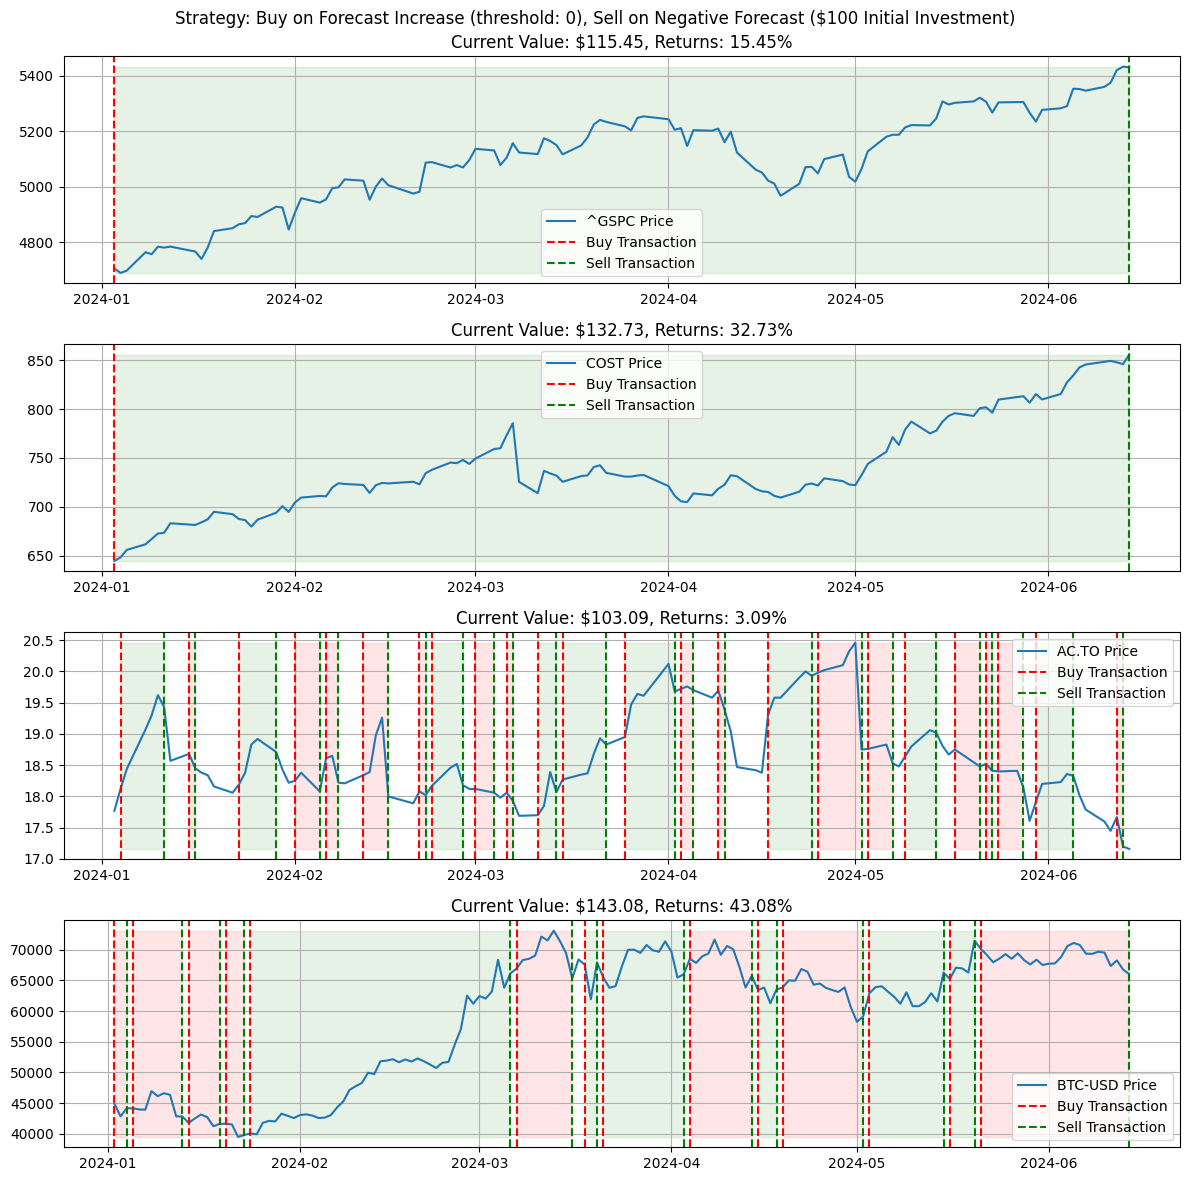

In [29]:
simulate_transactions(returns_test, 'nf', 0)

#### 7. Buy when positive returns forecasts, sell next day

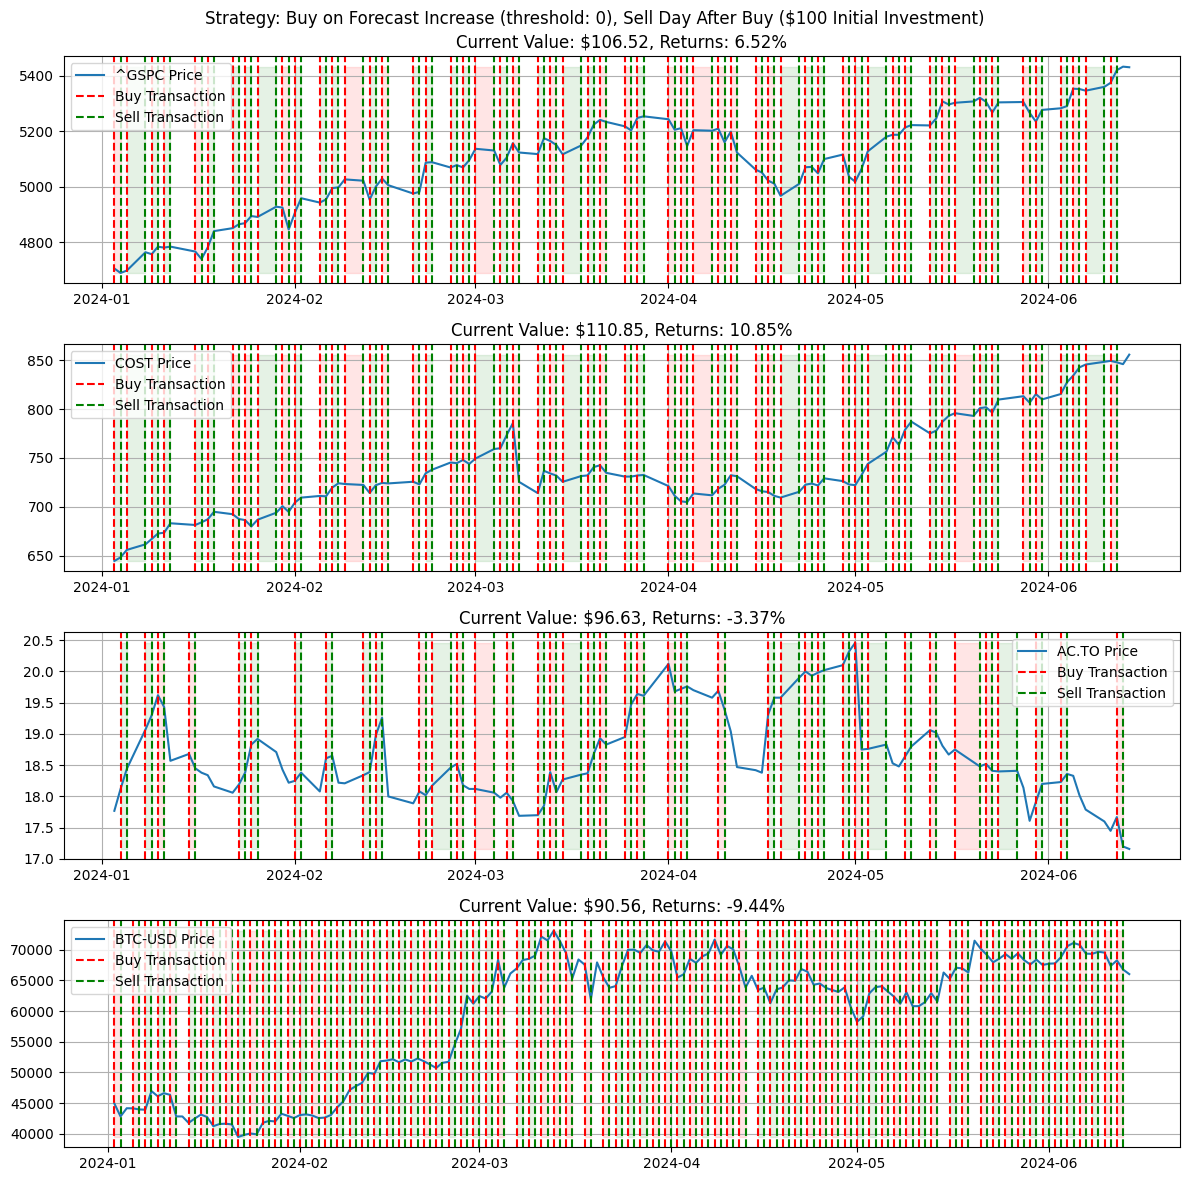

In [30]:
simulate_transactions(returns_test, 'ab', 0)

#### 8. buy when above threshold, sell next day

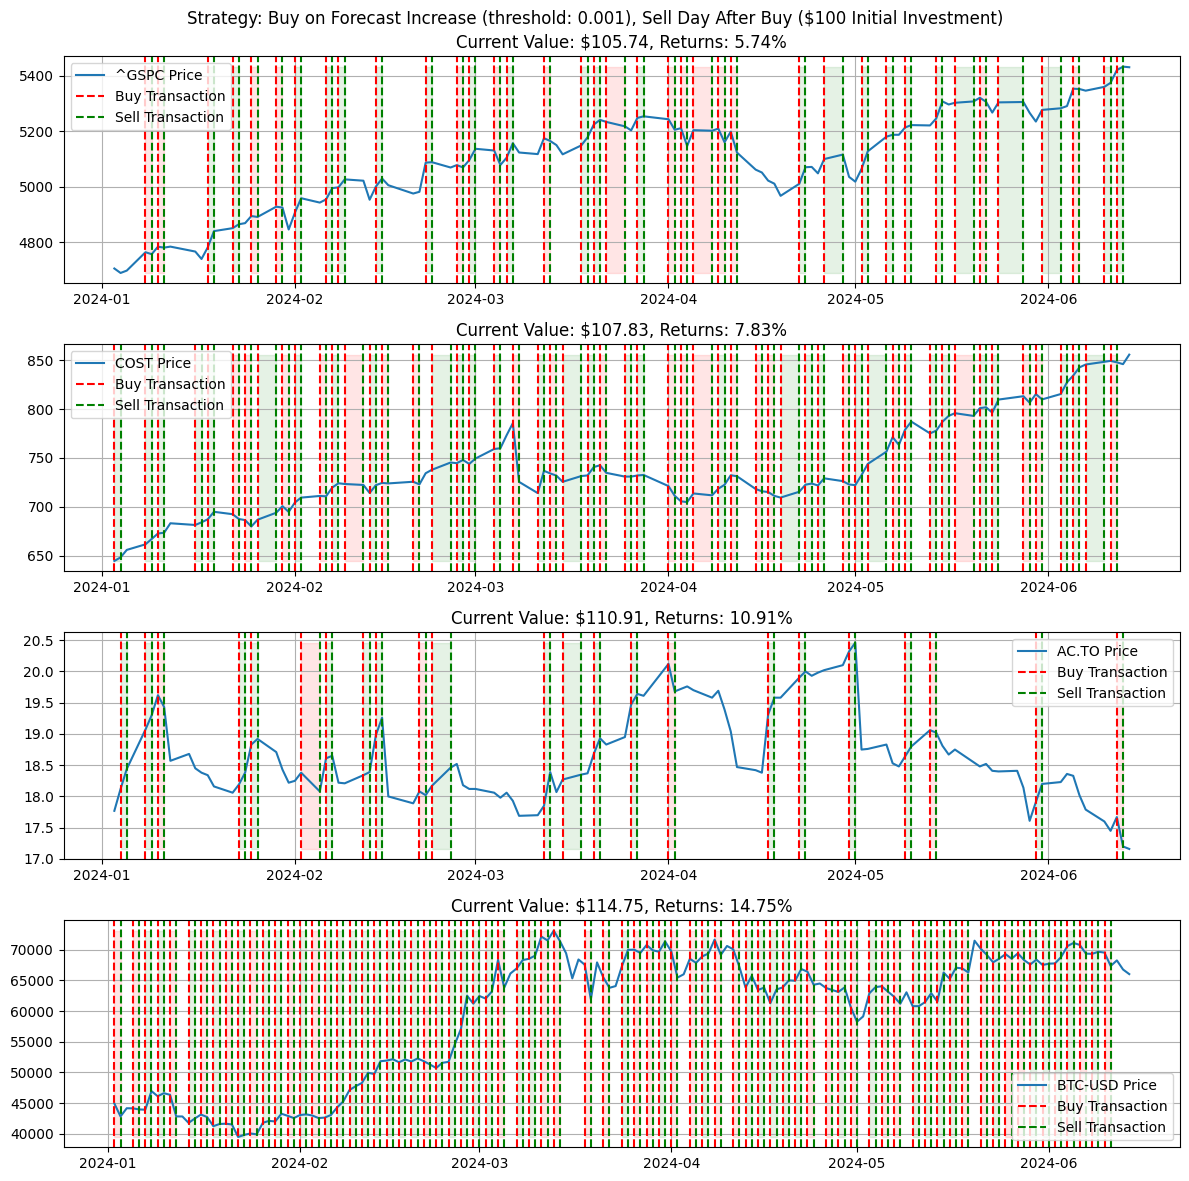

In [31]:
simulate_transactions(returns_test, 'ab', 0.001)

#### 9. Buy when above threshold, sell when below threshold

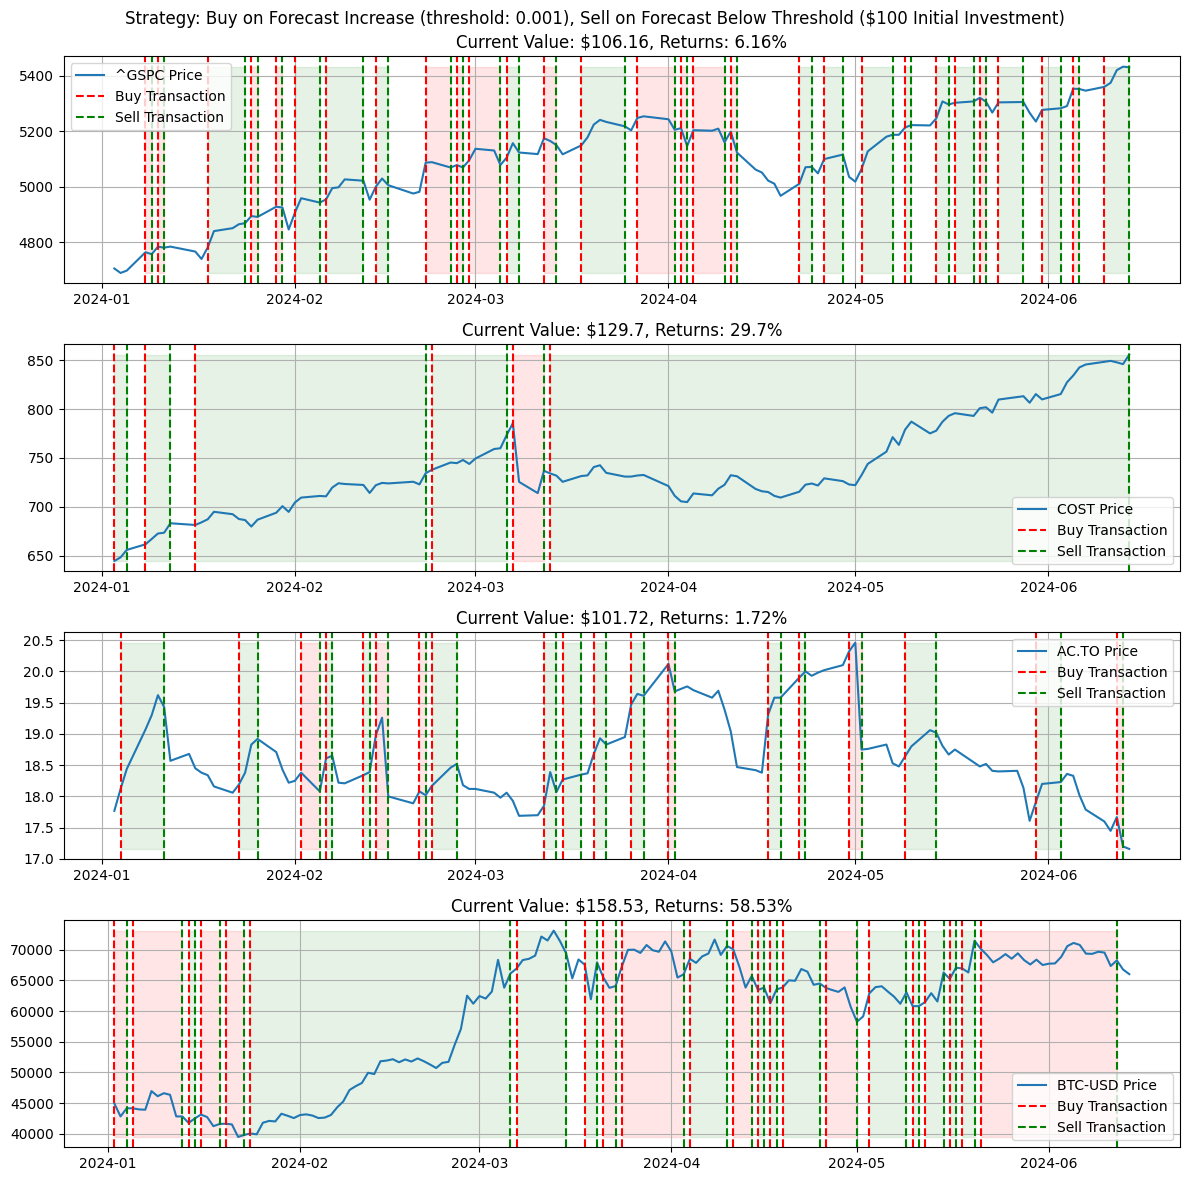

In [32]:
simulate_transactions(returns_test, 'bt', 0.001)